In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F


import matplotlib.pyplot as plt

import numpy as np

In [2]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

# Parameters
data_dir = "./fruit"
img_height, img_width = 300, 300
batch_size = 8

# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomRotation(47),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop((img_height, img_width), scale=(0.5, 1.0)),
    transforms.RandomAffine(degrees=0, shear=30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Assuming mean and std dev as 0.5 for simplicity
])

val_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Parameters for splitting
validation_split = 0.05
test_split = 0.05

# Calculate split sizes
total_size = len(full_dataset)
val_size = int(total_size * validation_split)
test_size = int(total_size * test_split)
train_size = total_size - val_size - test_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(123))

# Applying validation transforms to val_dataset and test_dataset
val_dataset.dataset.transform = val_transforms
test_dataset.dataset.transform = val_transforms

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
# OPTIMIZATION: ADAM
# FUNCTION: relu
# POOLING FUNCTION: MaxPooling
#
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.AvgPool2d(2, 2)

        # Calculate the size of the flattened layer
        with torch.no_grad():
            self._to_linear = None
            self.convs(torch.zeros(1, 3, img_height, img_width))

        self.fc1 = nn.Linear(self._to_linear, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 6)

    def convs(self, x):
        x = F.relu(self.pool(self.bn1(self.conv1(x))))

        if not self._to_linear:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # Flatten the layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = CustomCNN()
model.to(device)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=720000, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
)

In [5]:
class_names = full_dataset.classes
print(len(class_names))

6


Epoch [1/30]: Train Loss: 1.5796, Train Accuracy: 36.42%, Val Loss: 1.7596, Val Accuracy: 39.02%
Epoch [2/30]: Train Loss: 1.3100, Train Accuracy: 51.84%, Val Loss: 1.4830, Val Accuracy: 50.00%
Epoch [3/30]: Train Loss: 1.1243, Train Accuracy: 56.94%, Val Loss: 1.3057, Val Accuracy: 58.54%
Epoch [4/30]: Train Loss: 1.0089, Train Accuracy: 63.65%, Val Loss: 1.3150, Val Accuracy: 57.32%
Epoch [5/30]: Train Loss: 1.0021, Train Accuracy: 61.50%, Val Loss: 1.4776, Val Accuracy: 64.63%
Epoch [6/30]: Train Loss: 0.8874, Train Accuracy: 67.87%, Val Loss: 1.2553, Val Accuracy: 62.20%
Epoch [7/30]: Train Loss: 0.8415, Train Accuracy: 68.61%, Val Loss: 1.2329, Val Accuracy: 62.20%
Epoch [8/30]: Train Loss: 0.7567, Train Accuracy: 72.97%, Val Loss: 1.2619, Val Accuracy: 62.20%
Epoch [9/30]: Train Loss: 0.6406, Train Accuracy: 77.26%, Val Loss: 1.2379, Val Accuracy: 68.29%
Epoch [10/30]: Train Loss: 0.6053, Train Accuracy: 77.73%, Val Loss: 1.4610, Val Accuracy: 59.76%
Epoch [11/30]: Train Loss: 0.

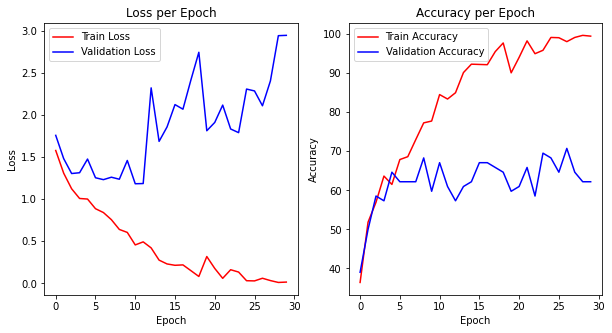

In [6]:
import torch.optim as optim
import matplotlib.pyplot as plt

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Initialize metrics storage
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 30

# Training loop
for epoch in range(epochs):
    # Initialize metrics for this epoch
    train_loss, val_loss = 0, 0
    correct_train, total_train, correct_val, total_val = 0, 0, 0, 0
    
    # Training phase
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()

    # Calculate average loss and accuracy for the epoch
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_accuracy = 100.0 * correct_train / total_train
    val_accuracy = 100.0 * correct_val / total_val

    # Append to history
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print epoch summary
    print(f'Epoch [{epoch+1}/{epochs}]: Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, color='red', label='Train Loss')
plt.plot(val_losses, color='blue', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, color='red', label='Train Accuracy')
plt.plot(val_accuracies, color='blue', label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [7]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to track correct predictions and total predictions
correct = 0
total = 0

with torch.no_grad():
    for data, targets in test_loader:
        # Move data to the appropriate device (CPU or GPU)
        data, targets = data.to(device), targets.to(device)

        # Make predictions
        outputs = model(data)

        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy}%')


Accuracy on test set: 63.41463414634146%
